<a href="https://colab.research.google.com/github/kangmg/compchem_archive/blob/main/bipyridine%20OPA%20spectrum/dihedral_scan_OPA_spectrums.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install conda

!rm -rf /content/sample_data
!rm -rf /content/condacolab_install.log

try:
  import condacolab
  condacolab.check()
except:
  %pip install condacolab
  import condacolab
  condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
#@title install packages
try: import psi4, aimnet2ase
except ModuleNotFoundError:
    from IPython.display import clear_output
    !pip install -q git+https://github.com/kangmg/aimnet2ase.git
    !conda install -q psi4 python=3.10 -c conda-forge/label/libint_dev -c conda-forge -y
    !conda install dftd3-python -c conda-forge -y
    !wget -q https://raw.githubusercontent.com/kangmg/wget_repo/refs/heads/main/bipyridine.xyz
    clear_output()

In [ ]:
#@title xyz reader

import ase
import re
from os.path import isfile
from io import StringIO

def read_traj(trajFile:str, returnString=False)->tuple[ase.Atoms|str]:
  """
  Description
  -----------
  Read trajectory data from a file or a string in XYZ format. If a file path is provided, it reads the content of the file. If a string is provided, it assumes the string contains trajectory data in XYZ format.

  Parameters
  ----------
    - trajFile (str) : The trajectory file path or trajectory format string to read.
    - returnString (bool) : Whether to return XYZ format strings. If false, returns ase.Atoms objects. Default is False.

  Returns
  -------
    - ase.Atoms objects(tuple)  <- if returnString == Fasle
    - xyz format strings(tuple) <- if returnString == True
  """
  if isfile(trajFile):
    with open(trajFile, "r") as file:
      traj = file.read()
  else:
    traj = trajFile

  # Split the trajectory file into multiple XYZ format strings
  pattern = re.compile("(\s?\d+\n.*\n(\s*[a-zA-Z]{1,2}(\s+-?\d+.\d+){3,3}\n?)+)")
  matched = pattern.findall(traj)

  xyzStringTuple = tuple(map(lambda groups : groups[0], matched))
  if returnString:
    return xyzStringTuple
  else:
    aseAtomsTuple = tuple(map(lambda xyzString : ase.io.read(StringIO(xyzString), format="xyz"), xyzStringTuple))
    return aseAtomsTuple

In [ ]:
from aimnet2ase.calculators.calculator import AIMNet2Calculator
from aimnet2ase import load_model, models
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import psi4
from psi4.driver.procrouting.response.scf_response import tdscf_excitations
from psi4.driver.p4util import spectrum

models()

wb97m_d3 = load_model('wb97m-d3')
calc = AIMNet2Calculator(wb97m_d3, charge=0)

xyz_strings = read_traj(trajFile='bipyridine.xyz', returnString=True)


- AIMNet2 models

    .____________.__________________________.
    |  Abbr.     |      Full Name           | 
    +____________+__________________________+ 
    |  b973c     | aimnet2_b973c_ens.jpt    | 
    |  wb97m-d3  | aimnet2_wb97m-d3_ens.jpt | 
    +____________+__________________________+ 

[Note] 
- Both `Abbr.' and `Full Name` are supported.



  0%|          | 0/19 [00:00<?, ?it/s]

Text(0.5, 1.0, "2,2'-bipyridine dihedral scan result")

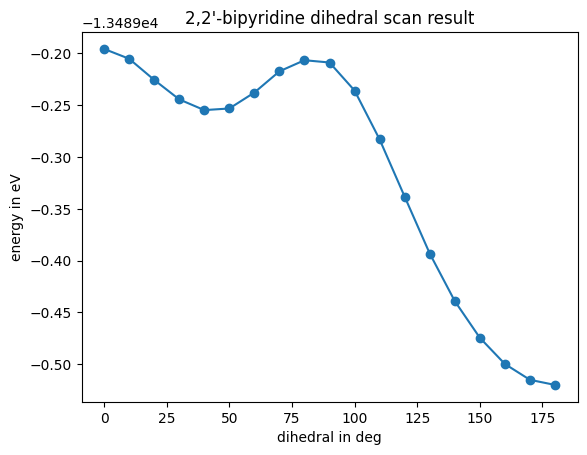

In [ ]:
dihedrals, energies = list(), list()

for atoms in tqdm(read_traj(trajFile='bipyridine.xyz', returnString=False)):
    # calculate
    _atoms = atoms
    _atoms.calc = calc
    energy = _atoms.get_potential_energy()
    dihedral = round(_atoms.get_dihedral(0,2,3,1))
    if dihedral >= 360:
        dihedral -= 360
    # save result
    dihedrals.append(dihedral)
    energies.append(energy)

# plot result
plt.plot(dihedrals, energies, 'o-')
plt.xlabel('dihedral in deg')
plt.ylabel('energy in eV')
plt.title("2,2'-bipyridine dihedral scan result")

In [ ]:
!rm -rf dihedral_*.out

# data container
psi4_energies = list()
opa_spectrums = list()

for xyz, angle in tqdm(zip(xyz_strings, dihedrals), total=len(xyz_strings)):
    print(f"Dihedral : {angle} | Calculation proceeding . . .")
    psi4.core.set_output_file(f'dihedral_{angle}.out', False)

    # setup
    molecule = psi4.geometry(xyz)
    psi4.set_options({
        'save_jk': True,
        })

    # calculate
    e, wfn = psi4.energy("b3lyp/6-31g", return_wfn=True, molecule=molecule)
    psi4_energies.append(e)
    res = tdscf_excitations(wfn, states=20, triplets="also")
    poles = [r["EXCITATION ENERGY"] for r in res]
    opa_residues = [np.linalg.norm(r["ELECTRIC DIPOLE TRANSITION MOMENT (LEN)"])**2 for r in res]

    # Generate OPA spectrum
    opa_spectrum = spectrum(poles=poles, residues=opa_residues, gamma=0.01, out_units="nm")
    opa_spectrums.append(opa_spectrum)


# runtime ~ 2시간 30분

  0%|          | 0/19 [00:00<?, ?it/s]

Dihedral : 0 | Calculation proceeding . . .
Dihedral : 10 | Calculation proceeding . . .
Dihedral : 20 | Calculation proceeding . . .
Dihedral : 30 | Calculation proceeding . . .
Dihedral : 40 | Calculation proceeding . . .
Dihedral : 50 | Calculation proceeding . . .
Dihedral : 60 | Calculation proceeding . . .
Dihedral : 70 | Calculation proceeding . . .
Dihedral : 80 | Calculation proceeding . . .
Dihedral : 90 | Calculation proceeding . . .
Dihedral : 100 | Calculation proceeding . . .
Dihedral : 110 | Calculation proceeding . . .
Dihedral : 120 | Calculation proceeding . . .
Dihedral : 130 | Calculation proceeding . . .
Dihedral : 140 | Calculation proceeding . . .
Dihedral : 150 | Calculation proceeding . . .
Dihedral : 160 | Calculation proceeding . . .
Dihedral : 170 | Calculation proceeding . . .
Dihedral : 180 | Calculation proceeding . . .


In [ ]:
#@title save outpus

import json

description = """
Calculation Description: Perform TD-SCF calculations by rotating the 2,2'-bipyridine dihedral from 0 deg to 180 deg in 10 deg increments.
Calculation Level: B3LYP/6-31G
"""

results = {
    'description' : description,
    'data': opa_spectrums,
    'energies' : psi4_energies
    }

def convert_np_array(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        print('skip')
        return obj

# json으로 저장
with open('data.json', 'w') as json_file:
    json.dump(results, json_file, indent=4, ensure_ascii=True, default=convert_np_array)

# 계산 로그 저장
!mkdir outputs
!mv dihedral_*.out outputs
!tar -czf outputs.tar.gz outputs

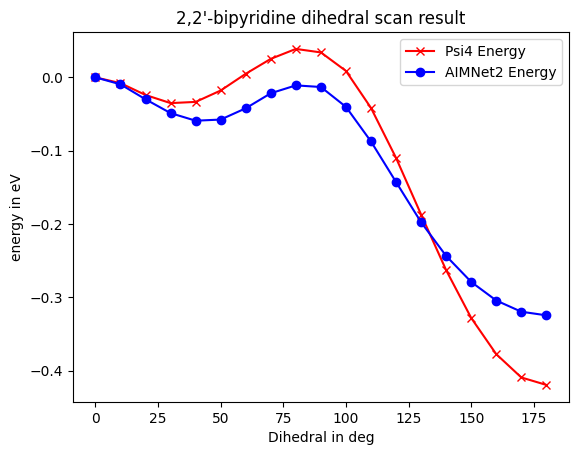

In [ ]:
# plot psi4 energies result

_psi4_energies_eV = [energy_Eh * 27.2114 for energy_Eh in psi4_energies]

normalize = lambda x : [x_i - x[0] for x_i in x]

plt.figure()
plt.plot(dihedrals, normalize(_psi4_energies_eV), 'x-', label='Psi4 Energy', color='red')
plt.plot(dihedrals, normalize(energies), 'o-', label='AIMNet2 Energy', color='blue')

plt.xlabel('Dihedral in deg')
plt.ylabel('energy in eV')
plt.title("2,2'-bipyridine dihedral scan result")
plt.legend()

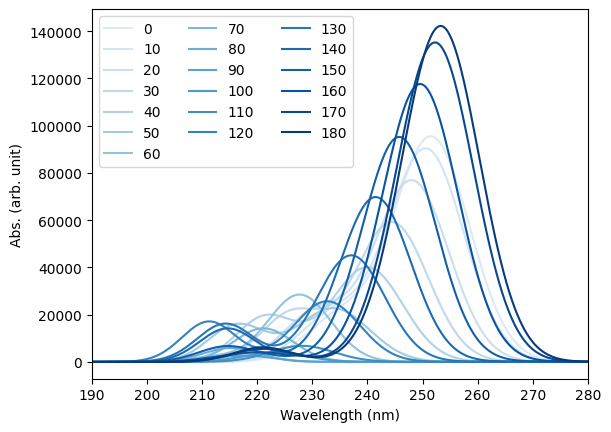

In [ ]:
from matplotlib import colors

blues = plt.cm.Blues
#reds = plt.cm.Reds

norm = colors.Normalize(vmin=0, vmax=len(opa_spectrums)+3)

plt.figure()

for idx, spectrum in enumerate(opa_spectrums):
    blue = blues(norm(idx + 3))
    #red = reds(norm(idx + 3))
    plt.plot(spectrum["convolution"]["x"], spectrum["convolution"]["y"], color=blue, label=f"{dihedrals[idx]}")
    #plt.vlines(spectrum['sticks']['poles'], 0,  spectrum['sticks']['residues'], color=red)

# 레이블 추가
#plt.title("OPA Spectrum Changes during 2,2'-bipyridine Rotation")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Abs. (arb. unit)")
plt.legend(ncol=3)
plt.xlim([190, 280])

plt.show()

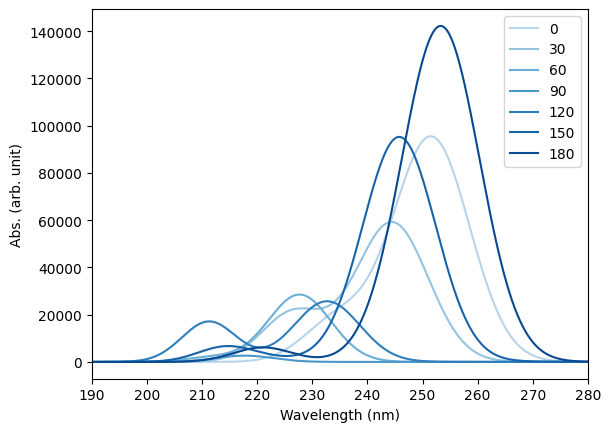

In [ ]:
from matplotlib import colors

interval = 3
blues = plt.cm.Blues
#reds = plt.cm.Reds

norm = colors.Normalize(vmin=0, vmax=len(opa_spectrums[::interval])+3)

plt.figure()

for idx, (dihedral, spectrum) in enumerate(zip(dihedrals[::interval], opa_spectrums[::interval])):
    blue = blues(norm(idx + 3))
    #red = reds(norm(idx + 3))
    plt.plot(spectrum["convolution"]["x"], spectrum["convolution"]["y"], color=blue, label=f"{dihedral}")
    #plt.vlines(spectrum['sticks']['poles'], 0,  spectrum['sticks']['residues'], color=red)

# 레이블 추가
#plt.title("OPA Spectrum Changes during 2,2'-bipyridine Rotation")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Abs. (arb. unit)")
plt.legend(ncol=1)
plt.xlim([190, 280])

# 그래프 보이기
plt.show()


<Figure size 640x480 with 0 Axes>

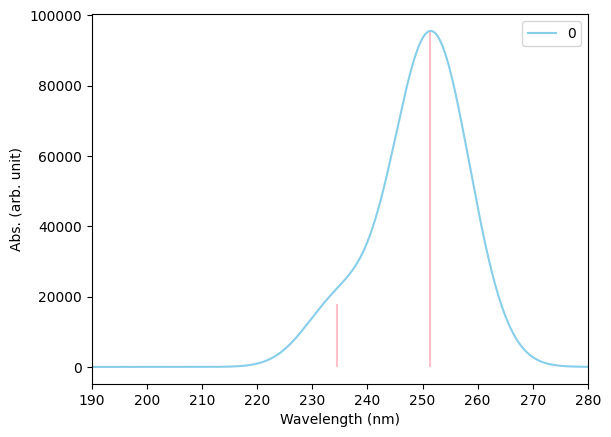

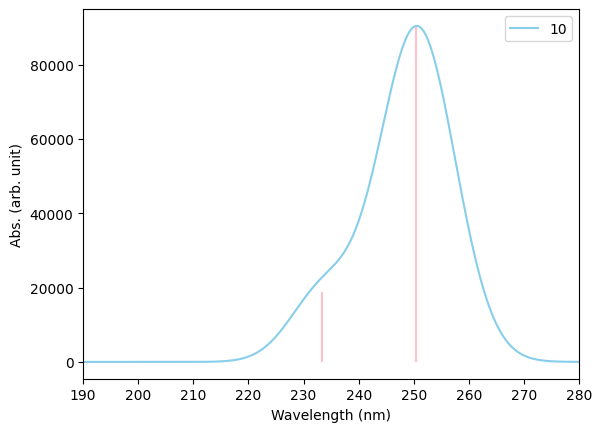

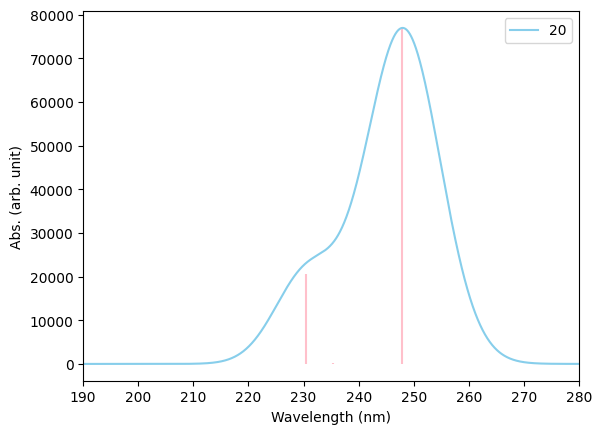

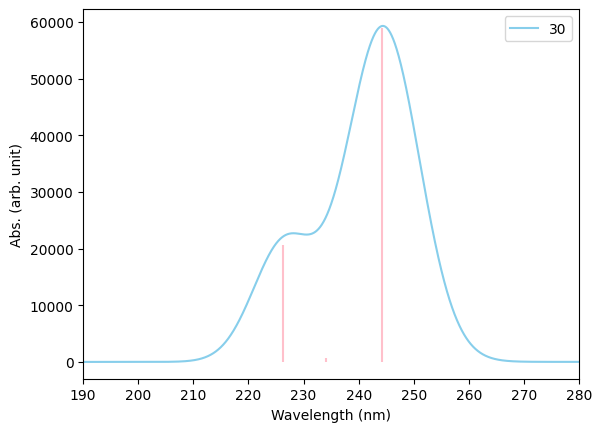

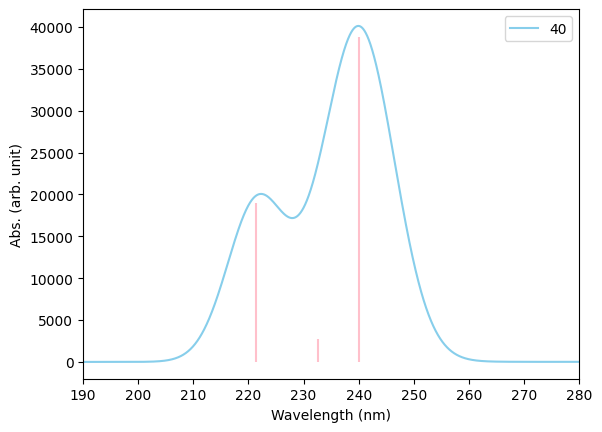

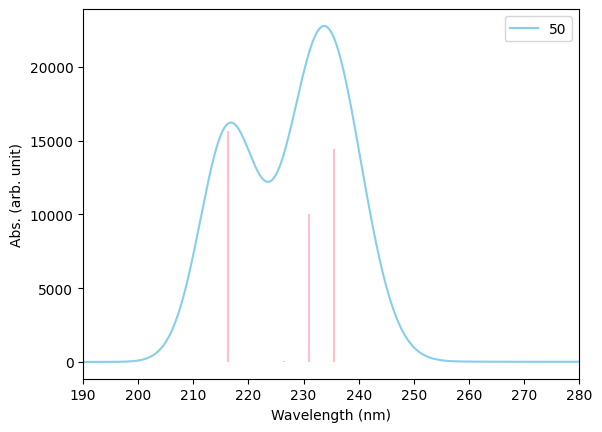

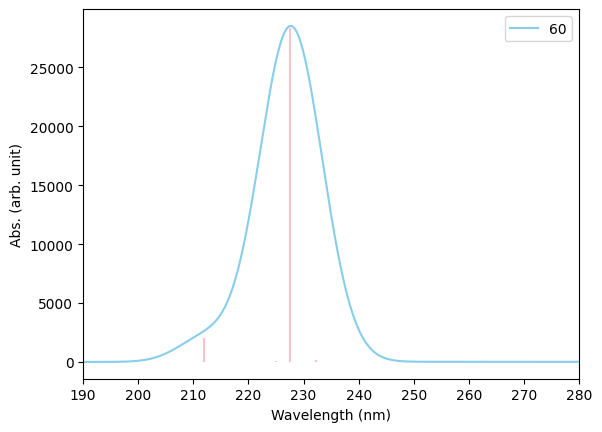

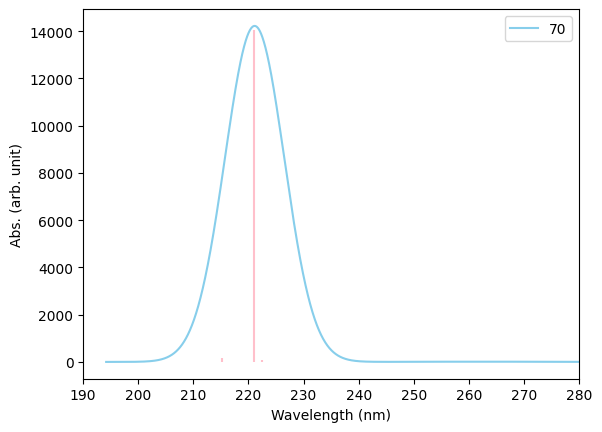

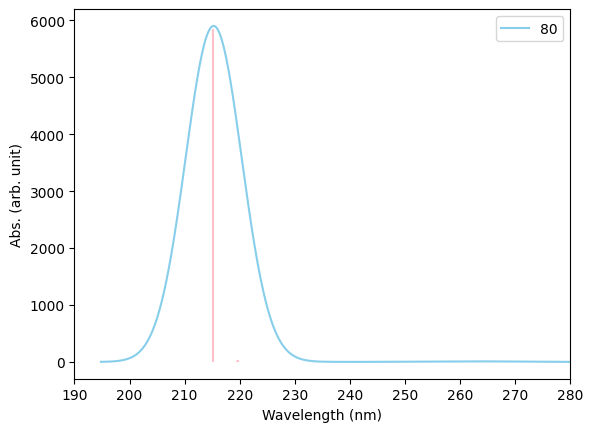

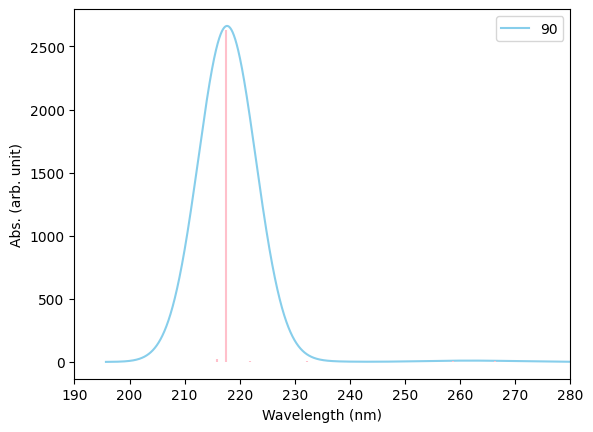

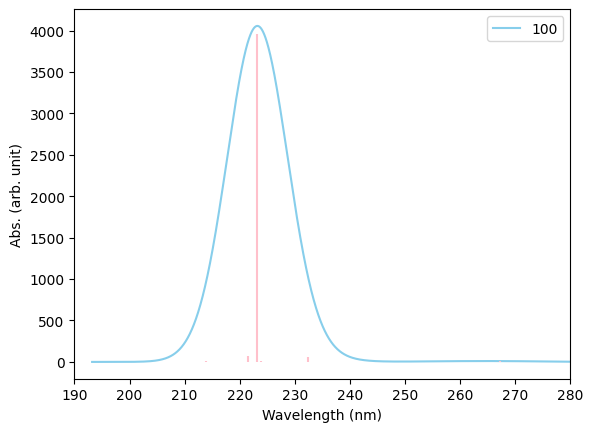

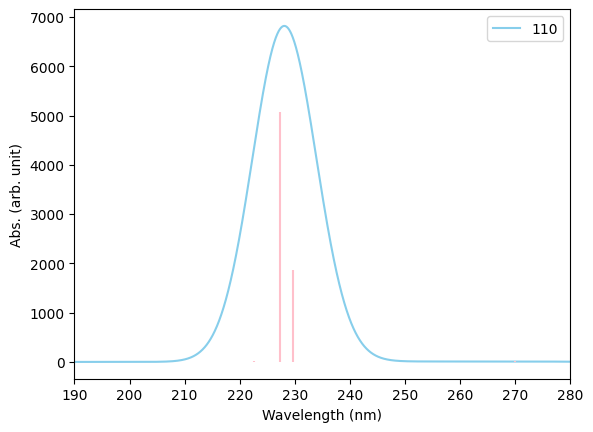

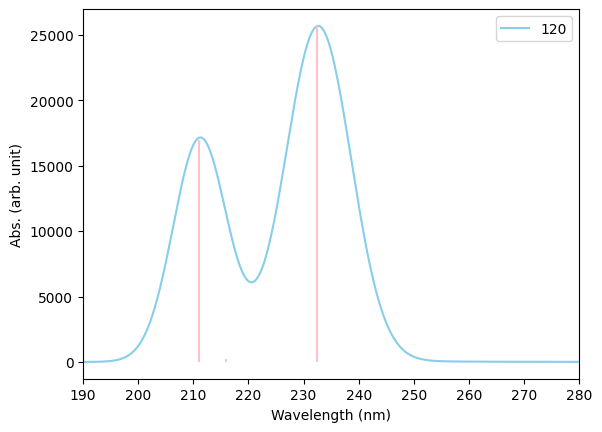

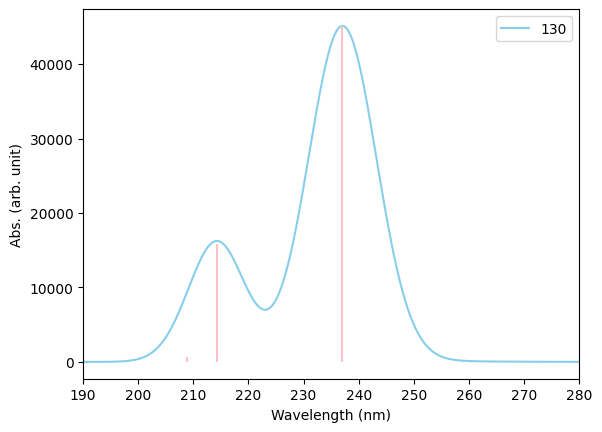

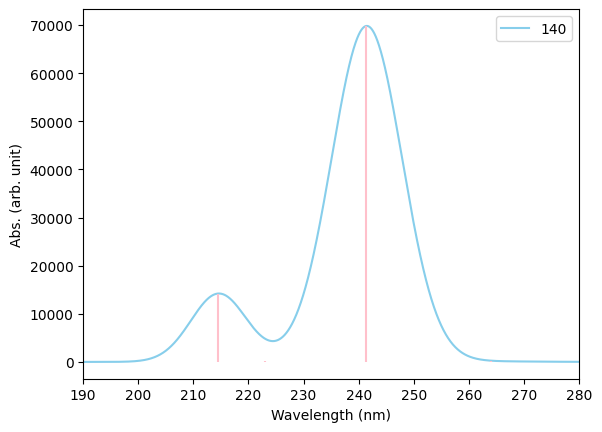

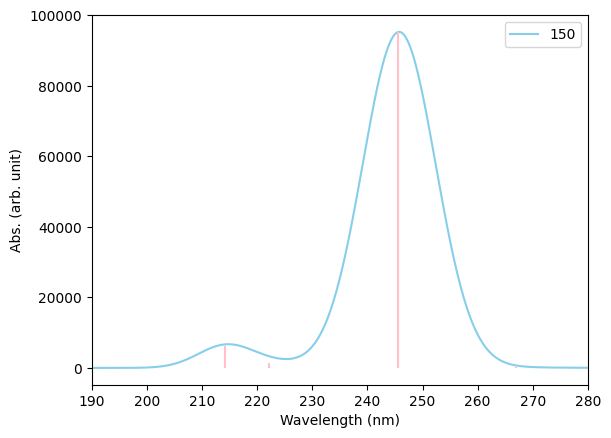

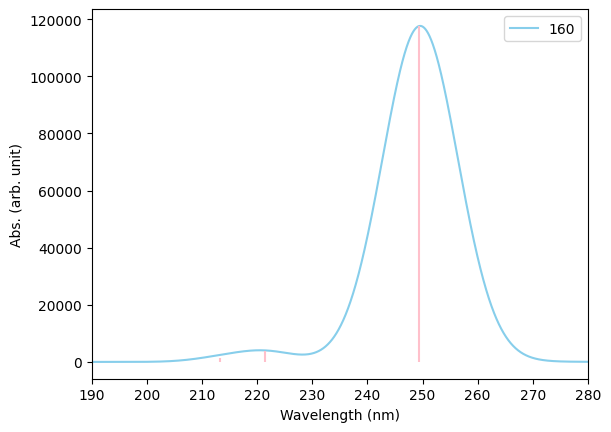

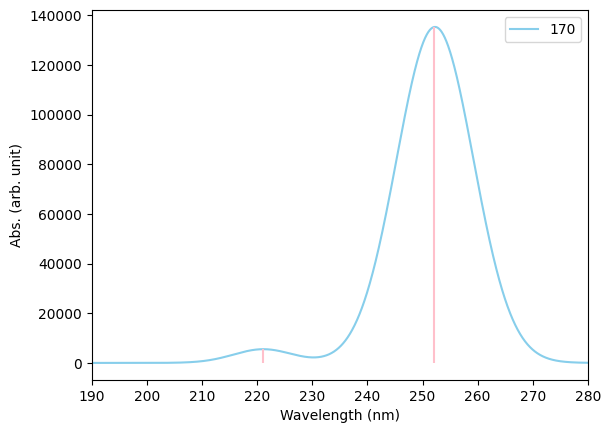

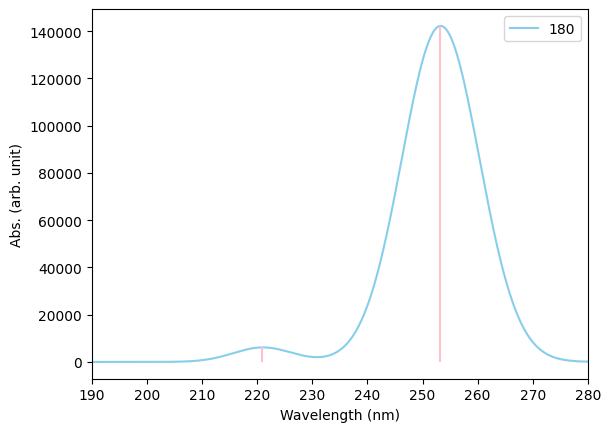

In [ ]:
from matplotlib import colors

interval = 1

plt.figure()

for idx, (dihedral, spectrum) in enumerate(zip(dihedrals[::interval], opa_spectrums[::interval])):
    plt.figure()
    plt.plot(spectrum["convolution"]["x"], spectrum["convolution"]["y"], color='skyblue', label=f"{dihedral}")
    plt.vlines(spectrum['sticks']['poles'], 0,  spectrum['sticks']['residues'], color='pink')

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Abs. (arb. unit)")
    plt.legend(ncol=1)
    plt.xlim([190, 280])

    plt.show()
